<h1>Support Vector Machine</h1>

<h5>Importing Packages</h5>

In [ ]:
try:
    from google.colab import drive
    drive.mount('/drive', force_remount=False)
    %run "/drive/My Drive/Colab Notebooks/Notebooks/Classical Machine Learning/Classical Methods - Processing.ipynb"
except:
    %run "/Google Drive/My Drive/Colab Notebooks/Notebooks/Classical Machine Learning/Classical Methods - Processing.ipynb"

<h5>Parameters</h5>

In [ ]:
datasets = getDataSets()

In [ ]:
sides = ['left', 'right']
kernel_types = ['poly', 'rbf', 'sigmoid']
window_sizes = [100, 150, 200, 250, 300]
window_fn = experiment_by_window_fn[0]
agg_fn_dict = experiment_by_agg_fn[5]
fields = experiment_by_fields[2]
agg_fn = getAggFunctions(fields, acc=agg_fn_dict["acc"], gyro=agg_fn_dict["gyro"], speed=agg_fn_dict["speed"])
save_path = os.path.join(work_folder, "SVM")
createPathIfNotExists(save_path)
subsets = getSubSets(datasets.copy(), fields, surface_type_labels)

<h5>Execution</h5>

In [ ]:
def searchBestModel(subsets, sets_train, sets_test, experiment_number, experiment_load_bar):
     
    execution_log = []
    experiment_path = os.path.join(save_path, "Experiment " + str(experiment_number)) 
    
    for window in window_sizes:

        features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
        input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

        for kernel in kernel_types:

            best_model = None

            for i in range(0, 3):         
                model, train_acc, val_acc = trainTestModel(input_train, input_test, output_train, output_test, kernel)
                new_model = (model, { "window": window, "kernel": kernel }, train_acc, val_acc)
                best_model = compareBestModel(best_model, new_model)
            
            execution_log.append([experiment_number, window, kernel, best_model[2], best_model[3]])

            file_prefix = "experiment-" + str(experiment_number) + "-window-" + str(window) + "-kernel-" + str(kernel)
            saveBestModel(experiment_path, file_prefix, best_model)

            experiment_load_bar.update(1)
            print("Experiment", str(experiment_number), "Window", str(window), "Kernel", kernel, "Train Acc", str(best_model[2]), "Val Acc", best_model[3])
    
    saveExecutionLog(experiment_path, "experiment", execution_log, ["experiment", "window", "kernel", "train_acc", "val_acc"])
           
def trainTestModel(x_train, x_test, y_train, y_test, kernel):
    
    # Build model
    model = SVC(kernel=kernel, gamma='scale', verbose=1)
    
    # Fit model
    model.fit(x_train.values, y_train.values.argmax(axis=1))
    
    # Test model
    y_train_pred = model.predict(x_train.values) 
    y_test_pred = model.predict(x_test.values) 
    
    return model, accuracy_score(y_train.values.argmax(axis=1), y_train_pred), accuracy_score(y_test.values.argmax(axis=1), y_test_pred)

def run():
    
    experiment_total_iteration = len(window_sizes) * len(kernel_types)
    experiment_total = len(experiment_by_dataset)
    
    load_bar_main = tqdm(total=experiment_total, desc='Main Progress')
    load_bar_experiment = tqdm(total=experiment_total_iteration)
    
    experiment_number = 0
  
    for dataset_dict in experiment_by_dataset:
        experiment_number += 1
        load_bar_experiment.reset()
        load_bar_experiment.set_description("Experiment " + str(experiment_number))
        searchBestModel(subsets, dataset_dict["train"], dataset_dict["test"], experiment_number, load_bar_experiment)
        load_bar_main.update(1)

In [ ]:
run()

<h5>Best Model - Confusion Matrix</h5>

In [ ]:
files = [
    'experiment-1-window-200-kernel-rbf-train-acc-0.7559438556-val-acc-0.6727748691.joblib',
    'experiment-2-window-200-kernel-rbf-train-acc-0.7702702703-val-acc-0.7560706402.joblib',
    'experiment-3-window-200-kernel-rbf-train-acc-0.7583543948-val-acc-0.7516304348.joblib'
]

0.6727748691099477
0.7560706401766004
0.7516304347826087


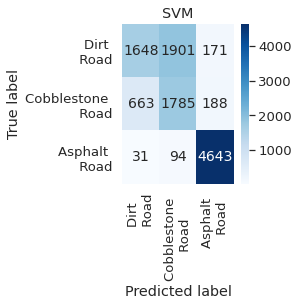

In [ ]:
matrix = []
window = 200

for experiment_number in range(0,3):

    sets_train = experiment_by_dataset[experiment_number]['train']
    sets_test = experiment_by_dataset[experiment_number]['test']

    features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
    input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

    path = os.path.join(work_folder, "SVM", "Experiment " + str(experiment_number + 1))
    model = loadBestModel(path, files[experiment_number])[0]
    y_pred = model.predict(input_test.values)
    y_true = output_test.copy().values.argmax(axis=1)

    print(accuracy_score(y_true, y_pred))
    matrix.append(confusion_matrix(y_true, y_pred))

result = (matrix[0] + matrix[1] + matrix[2])
plotConfusionMatrix(result, "SVM")

In [ ]:
output_values = []
predicted_values = []
window = 200

for experiment_number in range(0,3):

    sets_train = experiment_by_dataset[experiment_number]['train']
    sets_test = experiment_by_dataset[experiment_number]['test']

    features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
    input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

    path = os.path.join(work_folder, "SVM", "Experiment " + str(experiment_number + 1))
    model = loadBestModel(path, files[experiment_number])[0]
    y_pred = model.predict(input_test.values)
    y_true = output_test.copy().values.argmax(axis=1)

    for line in y_true:
        output_values.append(line)

    for line in y_pred:
        predicted_values.append(line)

    del input_train, input_test, output_train, output_test

classification_report(y_true = np.array(output_values), y_pred = np.array(predicted_values), output_dict=True, target_names=surface_type_labels)

{'accuracy': 0.7259978425026968,
 'asphalt_road': {'f1-score': 0.9504605936540429,
  'precision': 0.9282287085165933,
  'recall': 0.9737835570469798,
  'support': 4768},
 'cobblestone_road': {'f1-score': 0.5564214463840399,
  'precision': 0.4722222222222222,
  'recall': 0.6771623672230652,
  'support': 2636},
 'dirt_road': {'f1-score': 0.5437149455625206,
  'precision': 0.703672075149445,
  'recall': 0.443010752688172,
  'support': 3720},
 'macro avg': {'f1-score': 0.6835323285335345,
  'precision': 0.7013743352960868,
  'recall': 0.6979855589860723,
  'support': 11124},
 'weighted avg': {'f1-score': 0.7210664006385636,
  'precision': 0.7450766252733576,
  'recall': 0.7259978425026968,
  'support': 11124}}